In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import log_loss, make_scorer, accuracy_score, precision_recall_fscore_support
import xgboost as xgb

/Users/hoangnguyen/miniconda3/envs/pydata/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hoangnguyen/miniconda3/envs/pydata/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


build function to find optimal n_estimators
note: if learning_rate, reg_alpha, reg_lambda are not set
xgboost will use default values from https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
e.g. eta = 0.3 instead of 0.1
if they are set, eta, alpha, lambda will be overwritten
the best n_estimators is Name + 1

In [2]:
def modelfit(model, data, label, cv=5, early_stopping_rounds=50):
    params = model.get_params()
    params["num_class"] = 5
    dtrain = xgb.DMatrix(data, label)
    cvresult = xgb.cv(params, dtrain, num_boost_round=model.get_params()["n_estimators"],
                      nfold=cv, stratified=True,
                      metrics="mlogloss", early_stopping_rounds=early_stopping_rounds, verbose_eval=50)
    print(cvresult.iloc[-1])
    
def modelsubmit(model, train_data, train_label, test_data, label_list):
    model.fit(train_data, train_label, eval_metric="mlogloss")
    test_predict = model.predict_proba(test_data)
    sample = pd.read_csv("input/sample_submission.csv")
    sample[label_list] = test_predict
    sample.to_csv("submit/xgb_grid.csv", index=False)
    
# define scorer for log_loss
scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Load data

In [3]:
# load data
with open("preprocessed_data.pkl", "rb") as f:
    train_logit = pickle.load(f)
    test_data_logit = pickle.load(f)
    test_label_logit = pickle.load(f)
    train_data = pickle.load(f)
    train_label = pickle.load(f)
    test_data = pickle.load(f)
    test_label = pickle.load(f)
    label_list = pickle.load(f)

In [4]:
label_list

['Adoption', 'Died', 'Euthanasia', 'Return to Owner', 'Transfer']

# Find n-estimators

In [ ]:
xgb1 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=1000,
                         max_depth=5, min_child_weight=1,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
modelfit(xgb1, train_data, train_label)

[0]	train-mlogloss:1.53183+0.000899483	test-mlogloss:1.53257+0.0014405


# Grid search max_depth and min_child_weight
n-estimators = 103

In [6]:
# grid search max_depth and min_child_weight
param_grid = [{"max_depth": [3, 5, 7, 9],
               "min_child_weight": [1, 3, 5]}]
xgb2 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=103,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs2 = GridSearchCV(xgb2, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs2.fit(train_data, train_label)
gs2.grid_scores_, gs2.best_params_, gs2.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] min_child_weight=1, max_depth=3 .................................
[CV] ....... min_child_weight=1, max_depth=3, score=-0.950043 - 1.6min
[CV] min_child_weight=1, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] ....... min_child_weight=1, max_depth=3, score=-0.947148 - 1.7min
[CV] min_child_weight=1, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min remaining:    0.0s


[CV] ....... min_child_weight=1, max_depth=3, score=-0.949857 - 1.7min
[CV] min_child_weight=1, max_depth=3 .................................
[CV] ....... min_child_weight=1, max_depth=3, score=-0.944932 - 1.7min
[CV] min_child_weight=1, max_depth=3 .................................
[CV] ....... min_child_weight=1, max_depth=3, score=-0.931572 - 1.6min
[CV] min_child_weight=3, max_depth=3 .................................
[CV] ....... min_child_weight=3, max_depth=3, score=-0.950170 - 1.6min
[CV] min_child_weight=3, max_depth=3 .................................
[CV] ....... min_child_weight=3, max_depth=3, score=-0.947132 - 1.6min
[CV] min_child_weight=3, max_depth=3 .................................
[CV] ....... min_child_weight=3, max_depth=3, score=-0.949723 - 1.7min
[CV] min_child_weight=3, max_depth=3 .................................
[CV] ....... min_child_weight=3, max_depth=3, score=-0.945036 - 1.6min
[CV] min_child_weight=3, max_depth=3 .................................
[CV] .

KeyboardInterrupt: 

In [7]:
# grid search max_depth and min_child_weight, second time
param_grid = [{"max_depth": [3, 4, 5],
               "min_child_weight": [1, 2, 3]}]
xgb3 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=95,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs3 = GridSearchCV(xgb3, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs3.fit(train_data, train_label)
gs3.grid_scores_, gs3.best_params_, gs3.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] min_child_weight=1, max_depth=3 .................................
[CV] ....... min_child_weight=1, max_depth=3, score=-0.940883 -  13.9s
[CV] min_child_weight=1, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.9s remaining:    0.0s


[CV] ....... min_child_weight=1, max_depth=3, score=-0.933600 -  11.5s
[CV] min_child_weight=1, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.5s remaining:    0.0s


[CV] ....... min_child_weight=1, max_depth=3, score=-0.954039 -  12.5s
[CV] min_child_weight=1, max_depth=3 .................................
[CV] ....... min_child_weight=1, max_depth=3, score=-0.970437 -  14.0s
[CV] min_child_weight=1, max_depth=3 .................................
[CV] ....... min_child_weight=1, max_depth=3, score=-0.956340 -  13.9s
[CV] min_child_weight=2, max_depth=3 .................................
[CV] ....... min_child_weight=2, max_depth=3, score=-0.940884 -  13.2s
[CV] min_child_weight=2, max_depth=3 .................................
[CV] ....... min_child_weight=2, max_depth=3, score=-0.933567 -  13.8s
[CV] min_child_weight=2, max_depth=3 .................................
[CV] ....... min_child_weight=2, max_depth=3, score=-0.954152 -  13.3s
[CV] min_child_weight=2, max_depth=3 .................................
[CV] ....... min_child_weight=2, max_depth=3, score=-0.970716 -  14.6s
[CV] min_child_weight=2, max_depth=3 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 12.1min finished


([mean: -0.95106, std: 0.01281, params: {'min_child_weight': 1, 'max_depth': 3},
  mean: -0.95121, std: 0.01294, params: {'min_child_weight': 2, 'max_depth': 3},
  mean: -0.95119, std: 0.01293, params: {'min_child_weight': 3, 'max_depth': 3},
  mean: -0.94988, std: 0.01302, params: {'min_child_weight': 1, 'max_depth': 4},
  mean: -0.94998, std: 0.01294, params: {'min_child_weight': 2, 'max_depth': 4},
  mean: -0.95000, std: 0.01300, params: {'min_child_weight': 3, 'max_depth': 4},
  mean: -0.95174, std: 0.01287, params: {'min_child_weight': 1, 'max_depth': 5},
  mean: -0.95170, std: 0.01288, params: {'min_child_weight': 2, 'max_depth': 5},
  mean: -0.95162, std: 0.01297, params: {'min_child_weight': 3, 'max_depth': 5}],
 {'max_depth': 4, 'min_child_weight': 1},
 -0.9498809783208577)

In [9]:
# grid search max_depth and min_child_weight, third time
param_grid = [{"max_depth": [3, 4, 5],
               "min_child_weight": [1, 2, 3]}]
xgb4 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=85,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs4 = GridSearchCV(xgb4, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs4.fit(train_data, train_label)
gs4.grid_scores_, gs4.best_params_, gs4.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] max_depth=5, min_child_weight=7 .................................
[CV] ....... max_depth=5, min_child_weight=7, score=-0.965304 -   7.8s
[CV] max_depth=5, min_child_weight=7 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV] ....... max_depth=5, min_child_weight=7, score=-0.960033 -   7.4s
[CV] max_depth=5, min_child_weight=7 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s


[CV] ....... max_depth=5, min_child_weight=7, score=-0.956508 -   7.6s
[CV] max_depth=5, min_child_weight=7 .................................
[CV] ....... max_depth=5, min_child_weight=7, score=-0.963193 -   7.7s
[CV] max_depth=5, min_child_weight=7 .................................
[CV] ....... max_depth=5, min_child_weight=7, score=-0.946108 -   7.4s
[CV] max_depth=5, min_child_weight=9 .................................
[CV] ....... max_depth=5, min_child_weight=9, score=-0.965827 -   7.4s
[CV] max_depth=5, min_child_weight=9 .................................
[CV] ....... max_depth=5, min_child_weight=9, score=-0.960681 -   7.5s
[CV] max_depth=5, min_child_weight=9 .................................
[CV] ....... max_depth=5, min_child_weight=9, score=-0.956534 -   7.4s
[CV] max_depth=5, min_child_weight=9 .................................
[CV] ....... max_depth=5, min_child_weight=9, score=-0.962694 -   7.4s
[CV] max_depth=5, min_child_weight=9 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.0min finished


([mean: -0.95823, std: 0.00675, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: -0.95843, std: 0.00673, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: -0.95811, std: 0.00680, params: {'max_depth': 5, 'min_child_weight': 11}],
 {'max_depth': 5, 'min_child_weight': 11},
 -0.9581130389812961)

In [10]:
# grid search max_depth and min_child_weight, third time
param_grid = [{"max_depth": [5],
               "min_child_weight": [11, 13, 15]}]
xgb5 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=85,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs5 = GridSearchCV(xgb5, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs5.fit(train_data, train_label)
gs5.grid_scores_, gs5.best_params_, gs5.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] max_depth=5, min_child_weight=11 ................................
[CV] ...... max_depth=5, min_child_weight=11, score=-0.965184 -   8.8s
[CV] max_depth=5, min_child_weight=11 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV] ...... max_depth=5, min_child_weight=11, score=-0.960488 -   8.2s
[CV] max_depth=5, min_child_weight=11 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.0s remaining:    0.0s


[CV] ...... max_depth=5, min_child_weight=11, score=-0.956339 -   8.3s
[CV] max_depth=5, min_child_weight=11 ................................
[CV] ...... max_depth=5, min_child_weight=11, score=-0.962720 -   7.5s
[CV] max_depth=5, min_child_weight=11 ................................
[CV] ...... max_depth=5, min_child_weight=11, score=-0.945821 -   9.8s
[CV] max_depth=5, min_child_weight=13 ................................
[CV] ...... max_depth=5, min_child_weight=13, score=-0.965057 -   9.3s
[CV] max_depth=5, min_child_weight=13 ................................
[CV] ...... max_depth=5, min_child_weight=13, score=-0.960377 -   7.9s
[CV] max_depth=5, min_child_weight=13 ................................
[CV] ...... max_depth=5, min_child_weight=13, score=-0.955776 -   7.5s
[CV] max_depth=5, min_child_weight=13 ................................
[CV] ...... max_depth=5, min_child_weight=13, score=-0.961424 -   7.3s
[CV] max_depth=5, min_child_weight=13 ................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.0min finished


([mean: -0.95811, std: 0.00680, params: {'max_depth': 5, 'min_child_weight': 11},
  mean: -0.95772, std: 0.00658, params: {'max_depth': 5, 'min_child_weight': 13},
  mean: -0.95828, std: 0.00674, params: {'max_depth': 5, 'min_child_weight': 15}],
 {'max_depth': 5, 'min_child_weight': 13},
 -0.9577240488364236)

In [11]:
# grid search max_depth and min_child_weight, third time
param_grid = [{"max_depth": [5],
               "min_child_weight": [12, 13, 14]}]
xgb6 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=85,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs6 = GridSearchCV(xgb6, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs6.fit(train_data, train_label)
gs6.grid_scores_, gs6.best_params_, gs6.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] max_depth=5, min_child_weight=12 ................................
[CV] ...... max_depth=5, min_child_weight=12, score=-0.964886 -   7.7s
[CV] max_depth=5, min_child_weight=12 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV] ...... max_depth=5, min_child_weight=12, score=-0.959761 -   7.5s
[CV] max_depth=5, min_child_weight=12 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s


[CV] ...... max_depth=5, min_child_weight=12, score=-0.956055 -   7.9s
[CV] max_depth=5, min_child_weight=12 ................................
[CV] ...... max_depth=5, min_child_weight=12, score=-0.962792 -   8.2s
[CV] max_depth=5, min_child_weight=12 ................................
[CV] ...... max_depth=5, min_child_weight=12, score=-0.945987 -   7.4s
[CV] max_depth=5, min_child_weight=13 ................................
[CV] ...... max_depth=5, min_child_weight=13, score=-0.965057 -   7.5s
[CV] max_depth=5, min_child_weight=13 ................................
[CV] ...... max_depth=5, min_child_weight=13, score=-0.960377 -   7.7s
[CV] max_depth=5, min_child_weight=13 ................................
[CV] ...... max_depth=5, min_child_weight=13, score=-0.955776 -   8.4s
[CV] max_depth=5, min_child_weight=13 ................................
[CV] ...... max_depth=5, min_child_weight=13, score=-0.961424 -   8.2s
[CV] max_depth=5, min_child_weight=13 ................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.0min finished


([mean: -0.95790, std: 0.00666, params: {'max_depth': 5, 'min_child_weight': 12},
  mean: -0.95772, std: 0.00658, params: {'max_depth': 5, 'min_child_weight': 13},
  mean: -0.95800, std: 0.00685, params: {'max_depth': 5, 'min_child_weight': 14}],
 {'max_depth': 5, 'min_child_weight': 13},
 -0.9577240488364236)

# Grid search gamma
n_estimators = 96, max_depth = 4, min_child_weight = 1

In [8]:
param_grid = [{"gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5]}]
xgb7 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=96,
                         max_depth=4, min_child_weight=1,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs7 = GridSearchCV(xgb7, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs7.fit(train_data, train_label)
gs7.grid_scores_, gs7.best_params_, gs7.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] gamma=0 .........................................................
[CV] ............................... gamma=0, score=-0.941967 -  16.8s
[CV] gamma=0 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.8s remaining:    0.0s


[CV] ............................... gamma=0, score=-0.930680 -  16.6s
[CV] gamma=0 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.5s remaining:    0.0s


[CV] ............................... gamma=0, score=-0.951801 -  16.8s
[CV] gamma=0 .........................................................
[CV] ............................... gamma=0, score=-0.969605 -  17.1s
[CV] gamma=0 .........................................................
[CV] ............................... gamma=0, score=-0.955279 -  16.5s
[CV] gamma=0.1 .......................................................
[CV] ............................. gamma=0.1, score=-0.942131 -  16.8s
[CV] gamma=0.1 .......................................................
[CV] ............................. gamma=0.1, score=-0.930457 -  16.1s
[CV] gamma=0.1 .......................................................
[CV] ............................. gamma=0.1, score=-0.951798 -  16.2s
[CV] gamma=0.1 .......................................................
[CV] ............................. gamma=0.1, score=-0.969469 -  16.2s
[CV] gamma=0.1 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.9min finished


([mean: -0.94987, std: 0.01306, params: {'gamma': 0},
  mean: -0.94985, std: 0.01308, params: {'gamma': 0.1},
  mean: -0.94995, std: 0.01302, params: {'gamma': 0.2},
  mean: -0.94993, std: 0.01296, params: {'gamma': 0.3},
  mean: -0.94998, std: 0.01304, params: {'gamma': 0.4},
  mean: -0.94983, std: 0.01309, params: {'gamma': 0.5}],
 {'gamma': 0.5},
 -0.949831145151831)

# Find n-estimators
n_estimators = 96, max_depth = 4, min_child_weight = 1, gamma = 0.5

In [9]:
xgb8 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=1000,
                         max_depth=4, min_child_weight=1,
                         gamma=0.5,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
modelfit(xgb8, train_data, train_label)

[0]	train-mlogloss:1.53298+0.00128716	test-mlogloss:1.53335+0.000530566
[50]	train-mlogloss:0.943581+0.00289267	test-mlogloss:0.95494+0.0111297
[100]	train-mlogloss:0.916654+0.00280518	test-mlogloss:0.940868+0.0118311
[150]	train-mlogloss:0.904508+0.00303796	test-mlogloss:0.940503+0.0121356
test-mlogloss-mean     0.940365
test-mlogloss-std      0.012074
train-mlogloss-mean    0.909955
train-mlogloss-std     0.002902
Name: 125, dtype: float64


# Grid search subsample, colsample_bytree
n_estimators = 126, max_depth = 4, min_child_weight = 1, gamma = 0.5

In [10]:
param_grid9 = [{"subsample": [0.6, 0.7, 0.8, 0.9],
                 "colsample_bytree": [0.6, 0.7, 0.8, 0.9]}]
xgb9 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=126,
                         max_depth=4, min_child_weight=1,
                         gamma=0.5,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs9 = GridSearchCV(xgb9, param_grid9, fit_params={"eval_metric": "mlogloss"},
                    scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs9.fit(train_data, train_label)
gs9.grid_scores_, gs9.best_params_, gs9.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] subsample=0.6, colsample_bytree=0.6 .............................
[CV] ... subsample=0.6, colsample_bytree=0.6, score=-0.941359 -  16.5s
[CV] subsample=0.6, colsample_bytree=0.6 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.5s remaining:    0.0s


[CV] ... subsample=0.6, colsample_bytree=0.6, score=-0.928939 -  16.2s
[CV] subsample=0.6, colsample_bytree=0.6 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.7s remaining:    0.0s


[CV] ... subsample=0.6, colsample_bytree=0.6, score=-0.951598 -  16.3s
[CV] subsample=0.6, colsample_bytree=0.6 .............................
[CV] ... subsample=0.6, colsample_bytree=0.6, score=-0.967814 -  16.1s
[CV] subsample=0.6, colsample_bytree=0.6 .............................
[CV] ... subsample=0.6, colsample_bytree=0.6, score=-0.956958 -  16.3s
[CV] subsample=0.7, colsample_bytree=0.6 .............................
[CV] ... subsample=0.7, colsample_bytree=0.6, score=-0.941550 -  16.1s
[CV] subsample=0.7, colsample_bytree=0.6 .............................
[CV] ... subsample=0.7, colsample_bytree=0.6, score=-0.928813 -  15.6s
[CV] subsample=0.7, colsample_bytree=0.6 .............................
[CV] ... subsample=0.7, colsample_bytree=0.6, score=-0.952036 -  15.8s
[CV] subsample=0.7, colsample_bytree=0.6 .............................
[CV] ... subsample=0.7, colsample_bytree=0.6, score=-0.967670 -  15.7s
[CV] subsample=0.7, colsample_bytree=0.6 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 27.3min finished


([mean: -0.94933, std: 0.01330, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -0.94930, std: 0.01323, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -0.94925, std: 0.01345, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -0.94907, std: 0.01333, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: -0.94931, std: 0.01346, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: -0.94925, std: 0.01350, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -0.94947, std: 0.01312, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: -0.94963, std: 0.01323, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: -0.94981, std: 0.01308, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: -0.94982, std: 0.01313, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: -0.94983, std: 0.01283, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: -0.94987, std: 0.01302, params: {'subsample': 0.9, 'colsa

In [11]:
param_grid10 = [{"subsample": [0.55, 0.6, 0.65],
                 "colsample_bytree": [0.85, 0.9, 0.95]}]
xgb10 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=126,
                         max_depth=4, min_child_weight=1,
                         gamma=0.5,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs10 = GridSearchCV(xgb10, param_grid10, fit_params={"eval_metric": "mlogloss"},
                    scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs10.fit(train_data, train_label)
gs10.grid_scores_, gs10.best_params_, gs10.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] subsample=0.55, colsample_bytree=0.85 ...........................
[CV] . subsample=0.55, colsample_bytree=0.85, score=-0.942291 -  24.8s
[CV] subsample=0.55, colsample_bytree=0.85 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.8s remaining:    0.0s


[CV] . subsample=0.55, colsample_bytree=0.85, score=-0.929393 -  24.5s
[CV] subsample=0.55, colsample_bytree=0.85 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.3s remaining:    0.0s


[CV] . subsample=0.55, colsample_bytree=0.85, score=-0.953386 -  23.9s
[CV] subsample=0.55, colsample_bytree=0.85 ...........................
[CV] . subsample=0.55, colsample_bytree=0.85, score=-0.969059 -  23.9s
[CV] subsample=0.55, colsample_bytree=0.85 ...........................
[CV] . subsample=0.55, colsample_bytree=0.85, score=-0.956330 -  24.1s
[CV] subsample=0.6, colsample_bytree=0.85 ............................
[CV] .. subsample=0.6, colsample_bytree=0.85, score=-0.941608 -  24.2s
[CV] subsample=0.6, colsample_bytree=0.85 ............................
[CV] .. subsample=0.6, colsample_bytree=0.85, score=-0.929448 -  25.3s
[CV] subsample=0.6, colsample_bytree=0.85 ............................
[CV] .. subsample=0.6, colsample_bytree=0.85, score=-0.953674 -  23.2s
[CV] subsample=0.6, colsample_bytree=0.85 ............................
[CV] .. subsample=0.6, colsample_bytree=0.85, score=-0.968649 -  22.6s
[CV] subsample=0.6, colsample_bytree=0.85 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 18.2min finished


([mean: -0.95009, std: 0.01341, params: {'subsample': 0.55, 'colsample_bytree': 0.85},
  mean: -0.94999, std: 0.01340, params: {'subsample': 0.6, 'colsample_bytree': 0.85},
  mean: -0.95005, std: 0.01330, params: {'subsample': 0.65, 'colsample_bytree': 0.85},
  mean: -0.94990, std: 0.01339, params: {'subsample': 0.55, 'colsample_bytree': 0.9},
  mean: -0.94990, std: 0.01342, params: {'subsample': 0.6, 'colsample_bytree': 0.9},
  mean: -0.95021, std: 0.01311, params: {'subsample': 0.65, 'colsample_bytree': 0.9},
  mean: -0.95011, std: 0.01363, params: {'subsample': 0.55, 'colsample_bytree': 0.95},
  mean: -0.95054, std: 0.01367, params: {'subsample': 0.6, 'colsample_bytree': 0.95},
  mean: -0.95027, std: 0.01307, params: {'subsample': 0.65, 'colsample_bytree': 0.95}],
 {'colsample_bytree': 0.9, 'subsample': 0.55},
 -0.9498967911355714)

In [12]:
param_grid10 = [{"subsample": [0.55, 0.6],
                 "colsample_bytree": [0.9, 0.95, 0.1]}]
xgb10 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=126,
                         max_depth=4, min_child_weight=1,
                         gamma=0.5,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs10 = GridSearchCV(xgb10, param_grid10, fit_params={"eval_metric": "mlogloss"},
                    scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs10.fit(train_data, train_label)
gs10.grid_scores_, gs10.best_params_, gs10.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] subsample=0.55, colsample_bytree=0.9 ............................
[CV] .. subsample=0.55, colsample_bytree=0.9, score=-0.942010 -  22.3s
[CV] subsample=0.55, colsample_bytree=0.9 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.3s remaining:    0.0s


[CV] .. subsample=0.55, colsample_bytree=0.9, score=-0.929230 -  22.2s
[CV] subsample=0.55, colsample_bytree=0.9 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.6s remaining:    0.0s


[CV] .. subsample=0.55, colsample_bytree=0.9, score=-0.952780 -  22.1s
[CV] subsample=0.55, colsample_bytree=0.9 ............................
[CV] .. subsample=0.55, colsample_bytree=0.9, score=-0.968623 -  22.6s
[CV] subsample=0.55, colsample_bytree=0.9 ............................
[CV] .. subsample=0.55, colsample_bytree=0.9, score=-0.956845 -  23.9s
[CV] subsample=0.6, colsample_bytree=0.9 .............................
[CV] ... subsample=0.6, colsample_bytree=0.9, score=-0.941930 -  24.7s
[CV] subsample=0.6, colsample_bytree=0.9 .............................
[CV] ... subsample=0.6, colsample_bytree=0.9, score=-0.929297 -  23.9s
[CV] subsample=0.6, colsample_bytree=0.9 .............................
[CV] ... subsample=0.6, colsample_bytree=0.9, score=-0.953363 -  24.3s
[CV] subsample=0.6, colsample_bytree=0.9 .............................
[CV] ... subsample=0.6, colsample_bytree=0.9, score=-0.969007 -  24.3s
[CV] subsample=0.6, colsample_bytree=0.9 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  9.7min finished


([mean: -0.94990, std: 0.01339, params: {'subsample': 0.55, 'colsample_bytree': 0.9},
  mean: -0.94990, std: 0.01342, params: {'subsample': 0.6, 'colsample_bytree': 0.9},
  mean: -0.95011, std: 0.01363, params: {'subsample': 0.55, 'colsample_bytree': 0.95},
  mean: -0.95054, std: 0.01367, params: {'subsample': 0.6, 'colsample_bytree': 0.95},
  mean: -0.98452, std: 0.01131, params: {'subsample': 0.55, 'colsample_bytree': 0.1},
  mean: -0.98449, std: 0.01128, params: {'subsample': 0.6, 'colsample_bytree': 0.1}],
 {'colsample_bytree': 0.9, 'subsample': 0.55},
 -0.9498967911355714)

# Grid search reg_alpha
n_estimators = 85, max_depth = 5, min_child_weight = 13, gamma = 0.4, colsample_bytree = 0.75, subsample = 0.85

In [13]:
param_grid11 = [{"reg_alpha": [0.001, 0.005, 0.01, 0.05]}]
xgb11 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=126,
                         max_depth=4, min_child_weight=1,
                         gamma=0.5,
                         subsample=0.55, colsample_bytree=0.9,
                         reg_lambda=1,
                         objective="multi:softprob")
gs11 = GridSearchCV(xgb11, param_grid11, fit_params={"eval_metric": "mlogloss"},
                    scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs11.fit(train_data, train_label)
gs11.grid_scores_, gs11.best_params_, gs11.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] reg_alpha=0.001 .................................................
[CV] ....................... reg_alpha=0.001, score=-0.941995 -  24.6s
[CV] reg_alpha=0.001 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.6s remaining:    0.0s


[CV] ....................... reg_alpha=0.001, score=-0.928971 -  25.7s
[CV] reg_alpha=0.001 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.4s remaining:    0.0s


[CV] ....................... reg_alpha=0.001, score=-0.952838 -  25.4s
[CV] reg_alpha=0.001 .................................................
[CV] ....................... reg_alpha=0.001, score=-0.968411 -  25.0s
[CV] reg_alpha=0.001 .................................................
[CV] ....................... reg_alpha=0.001, score=-0.956844 -  27.0s
[CV] reg_alpha=0.005 .................................................
[CV] ....................... reg_alpha=0.005, score=-0.941654 -  25.3s
[CV] reg_alpha=0.005 .................................................
[CV] ....................... reg_alpha=0.005, score=-0.929150 -  24.4s
[CV] reg_alpha=0.005 .................................................
[CV] ....................... reg_alpha=0.005, score=-0.953064 -  24.7s
[CV] reg_alpha=0.005 .................................................
[CV] ....................... reg_alpha=0.005, score=-0.968624 -  24.4s
[CV] reg_alpha=0.005 .................................................
[CV] .

KeyboardInterrupt: 

# Grid search reg_lambda
n_estimators = 85, max_depth = 5, min_child_weight = 13, 
gamma = 0.4, colsample_bytree = 0.75, subsample = 0.85, reg_alpha = 0.001

In [26]:
param_grid12 = [{"reg_lambda": [1e-5, 0.01, 0.1, 1, 100]}]
xgb12 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=85,
                         max_depth=5, min_child_weight=13,
                         gamma=0.4,
                         subsample=0.85, colsample_bytree=0.75,
                         reg_alpha=0.001,
                         objective="multi:softprob")
gs12 = GridSearchCV(xgb12, param_grid12, fit_params={"eval_metric": "mlogloss"},
                    scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs12.fit(train_data, train_label)
gs12.grid_scores_, gs12.best_params_, gs12.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] reg_lambda=1e-05 ................................................
[CV] ...................... reg_lambda=1e-05, score=-0.965795 -   8.4s
[CV] reg_lambda=1e-05 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV] ...................... reg_lambda=1e-05, score=-0.959856 -   7.8s
[CV] reg_lambda=1e-05 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.2s remaining:    0.0s


[CV] ...................... reg_lambda=1e-05, score=-0.954785 -   7.3s
[CV] reg_lambda=1e-05 ................................................
[CV] ...................... reg_lambda=1e-05, score=-0.961551 -   8.0s
[CV] reg_lambda=1e-05 ................................................
[CV] ...................... reg_lambda=1e-05, score=-0.946544 -   7.1s
[CV] reg_lambda=0.01 .................................................
[CV] ....................... reg_lambda=0.01, score=-0.965929 -   7.1s
[CV] reg_lambda=0.01 .................................................
[CV] ....................... reg_lambda=0.01, score=-0.960206 -   7.4s
[CV] reg_lambda=0.01 .................................................
[CV] ....................... reg_lambda=0.01, score=-0.955732 -   7.1s
[CV] reg_lambda=0.01 .................................................
[CV] ....................... reg_lambda=0.01, score=-0.961692 -   7.2s
[CV] reg_lambda=0.01 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.1min finished


([mean: -0.95771, std: 0.00660, params: {'reg_lambda': 1e-05},
  mean: -0.95815, std: 0.00639, params: {'reg_lambda': 0.01},
  mean: -0.95781, std: 0.00662, params: {'reg_lambda': 0.1},
  mean: -0.95806, std: 0.00650, params: {'reg_lambda': 1},
  mean: -0.96680, std: 0.00625, params: {'reg_lambda': 100}],
 {'reg_lambda': 1e-05},
 -0.9577090136342575)

# Find n_estimators final
n_estimators = 85, max_depth = 5, min_child_weight = 13, 
gamma = 0.4, colsample_bytree = 0.75, subsample = 0.85, reg_alpha = 0.001, reg_lambda = 1e-05

In [27]:
# find n_estimators
xgb13 = xgb.XGBClassifier(learning_rate=0.01, n_estimators=5000,
                         max_depth=5, min_child_weight=13,
                         gamma=0.4,
                         subsample=0.85, colsample_bytree=0.75,
                         reg_alpha=0.001, reg_lambda=1e-05,
                         objective="multi:softprob")
modelfit(xgb13, train_data, train_label)

[0]	train-mlogloss:1.60187+0.000139131	test-mlogloss:1.60196+9.99232e-05
[50]	train-mlogloss:1.33546+0.0016812	test-mlogloss:1.33953+0.0034284
[100]	train-mlogloss:1.19105+0.00170778	test-mlogloss:1.19851+0.00492195
[150]	train-mlogloss:1.10441+0.00184549	test-mlogloss:1.11495+0.00597063
[200]	train-mlogloss:1.04958+0.00177894	test-mlogloss:1.06284+0.00674848
[250]	train-mlogloss:1.01341+0.00170158	test-mlogloss:1.02936+0.00729334
[300]	train-mlogloss:0.988569+0.0017109	test-mlogloss:1.00712+0.00750821
[350]	train-mlogloss:0.970903+0.00170364	test-mlogloss:0.991925+0.00762137
[400]	train-mlogloss:0.957944+0.00170679	test-mlogloss:0.981381+0.00775022
[450]	train-mlogloss:0.948187+0.00171127	test-mlogloss:0.973971+0.00786957
[500]	train-mlogloss:0.940564+0.00173644	test-mlogloss:0.968722+0.00793126
[550]	train-mlogloss:0.934471+0.00174271	test-mlogloss:0.964925+0.00795334
[600]	train-mlogloss:0.92941+0.0017553	test-mlogloss:0.962169+0.00798972
[650]	train-mlogloss:0.92512+0.00172159	test

In [5]:
xgbfinal = xgb.XGBClassifier(learning_rate=0.01, n_estimators=1007,
                         max_depth=5, min_child_weight=13,
                         gamma=0.4,
                         subsample=0.85, colsample_bytree=0.75,
                         reg_alpha=0.001, reg_lambda=1e-05,
                         objective="multi:softprob")

In [6]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}

In [ ]:
xgbfinal.fit(train_data,train_label)

# Predict

In [9]:
predict_label = xgbfinal.predict(test_data)
predict_proba_label = xgbfinal.predict_proba(test_data)

Accuracy: 59.53% (0.81%)


# Accuracy and score

In [10]:
# Accuracy
xgbfinal.score(test_data, test_label)

[-0.97987352 -0.96069905 -0.96074928 -0.95652849 -0.93729479 -0.9648771
 -0.96537267 -0.95666067 -0.95091782 -0.93622987]


In [ ]:
accuracy_score(test_label, predict_label)

In [ ]:
# Log-loss
log_loss(test_label, predict_proba_label, eps=1e-15, normalize=True)

In [11]:
precision_recall_fscore_support(test_label, predict_label, beta=0.5, average=None)

Accuracy: -0.96 (+/- 0.02)


# Feature importances

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [13]:
features = ['Size', 'HasName_0', 'HasName_1', 'TimeofDay_lateday',
       'TimeofDay_midday', 'TimeofDay_morning', 'TimeofDay_night', 'WeekDay_0',
       'WeekDay_1', 'WeekDay_2', 'WeekDay_3', 'WeekDay_4', 'WeekDay_5',
       'WeekDay_6', 'IsIntact_0', 'IsIntact_1','Sex_Female', 'Sex_Male', 'IsMixBreed_0', 
        'IsMixBreed_1','MixorMultipleorSimple_Mix', 'MixorMultipleorSimple_Multiple',
       'MixorMultipleorSimple_Simple', 'Group_Herding', 'Group_Hound',
       'Group_NonSporting', 'Group_PitBull', 'Group_Sporting', 'Group_Terrier',
       'Group_Toy', 'Group_Unknown', 'Group_Working', 'IsMixColor_0',
       'IsMixColor_1']
mapFeat = dict(zip(["f"+str(i) for i in range(len(features))],features))
ts = pd.Series(xgbfinal.booster().get_fscore())
#ts.index = ts.reset_index()['index'].map(mapFeat)
#ts.order().plot(kind="barh", title=("features importance"))

In [14]:
ts = ts.sort_values(ascending=False)

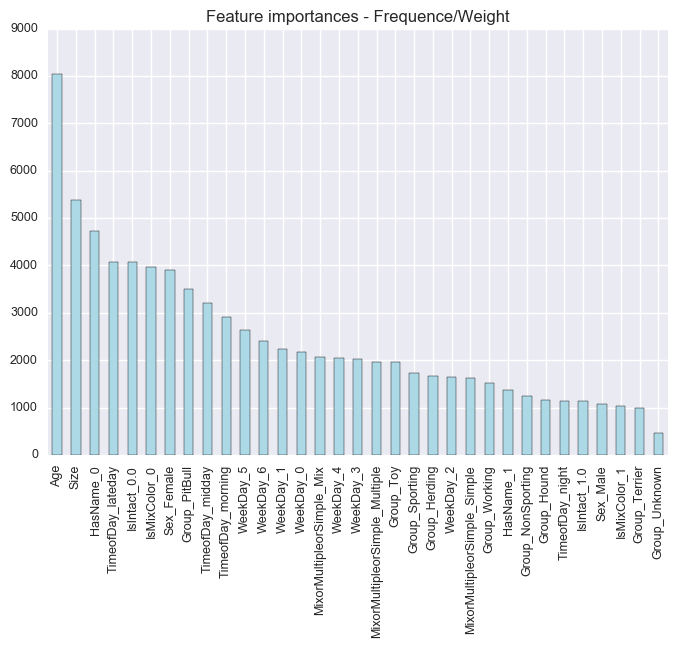

In [15]:
plt.figure(); ts.plot(color="lightblue", kind="bar", title="Feature importances - Frequence/Weight",fontsize=9,)

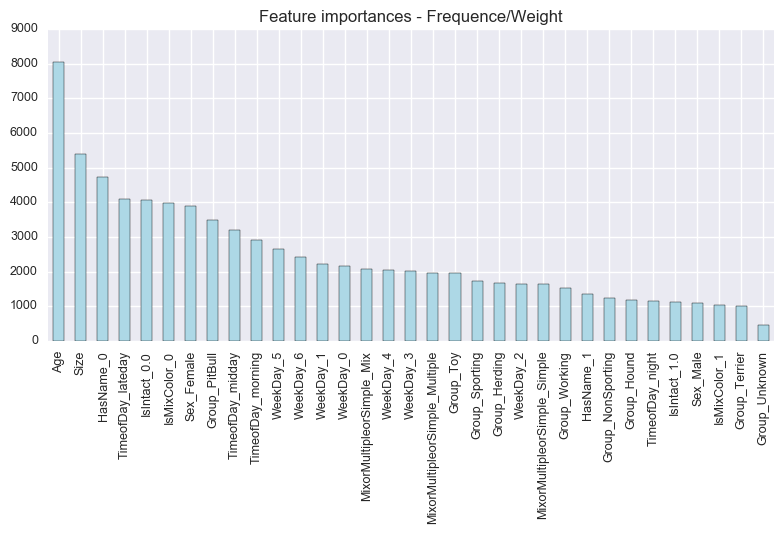

In [16]:
plt.figure(); ts.plot(color="lightblue", kind="bar", title="Feature importances - Frequence/Weight",fontsize=9)
plt.tight_layout(rect=[0,0,1,1], h_pad=0.0)
plt.savefig("gain.png")

In [17]:
#xgb.plot_importance(xgbfinal)

In [18]:
ts1 = pd.Series(xgbfinal.booster().get_score(importance_type = "gain"))

In [19]:
ts1 = ts1.sort_values(ascending=False)

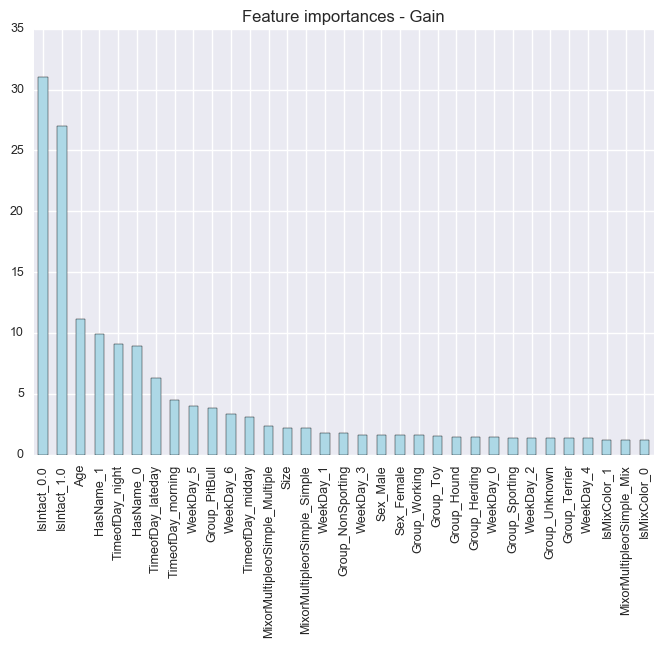

In [20]:
plt.figure(); ts1.plot(color="lightblue", kind="bar", title="Feature importances - Gain",fontsize=9)

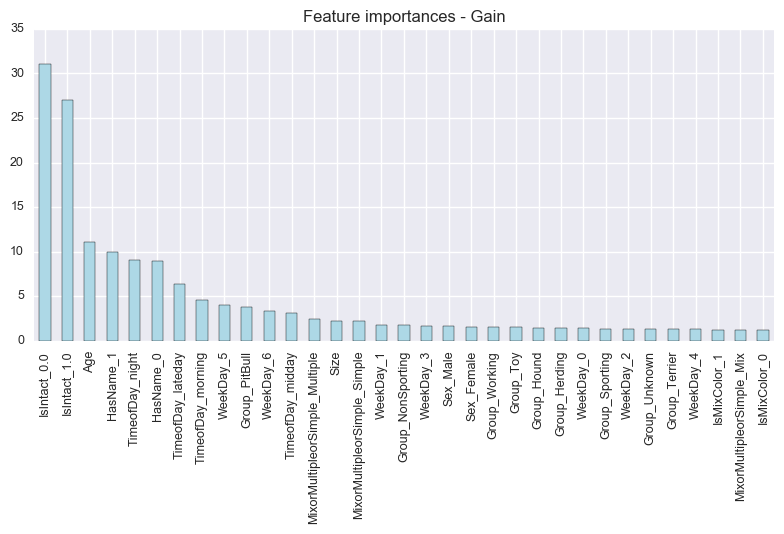

In [21]:
plt.figure(); ts1.plot(color="lightblue", kind="bar", title="Feature importances - Gain",fontsize=9)
plt.tight_layout(rect=[0,0,1,1], h_pad=0.0)
plt.savefig("gain.png")

In [22]:
ts2 = pd.Series(xgbfinal.booster().get_score(importance_type = "weight"))

In [23]:
ts2 = ts2.sort_values(ascending=False)

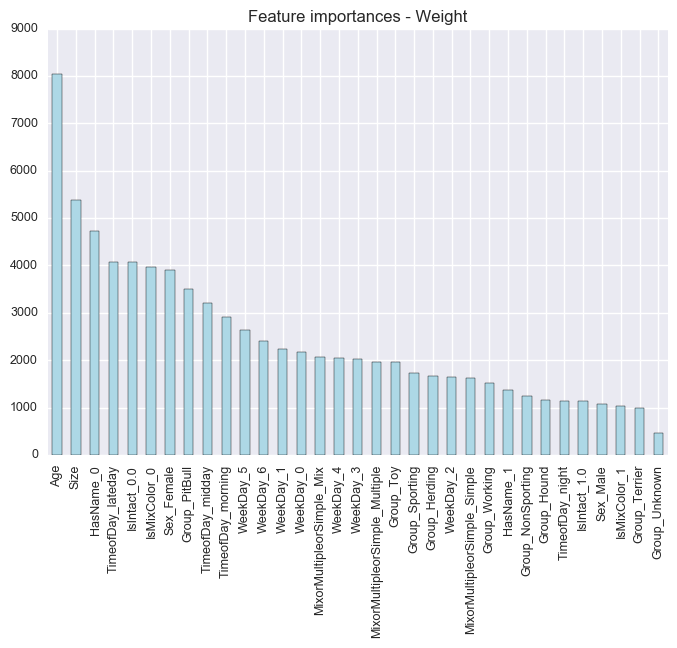

In [24]:
plt.figure(); ts2.plot(color="lightblue", kind="bar", title="Feature importances - Weight",fontsize=9,)

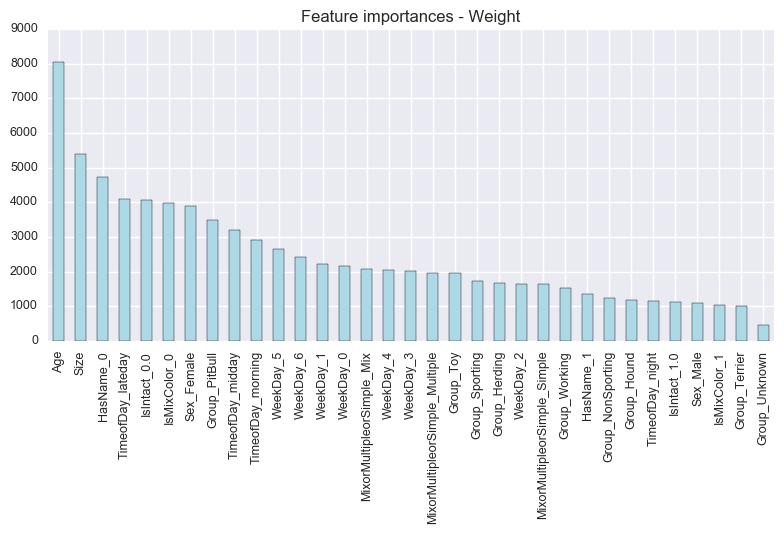

In [25]:
plt.figure(); ts2.plot(color="lightblue", kind="bar", title="Feature importances - Weight",fontsize=9,)
plt.tight_layout(rect=[0,0,1,1], h_pad=0.0)
plt.savefig("weight.png")

In [26]:
ts3 = pd.Series(xgbfinal.booster().get_score(importance_type = "cover"))

In [27]:
ts3 = ts3.sort_values(ascending=False)

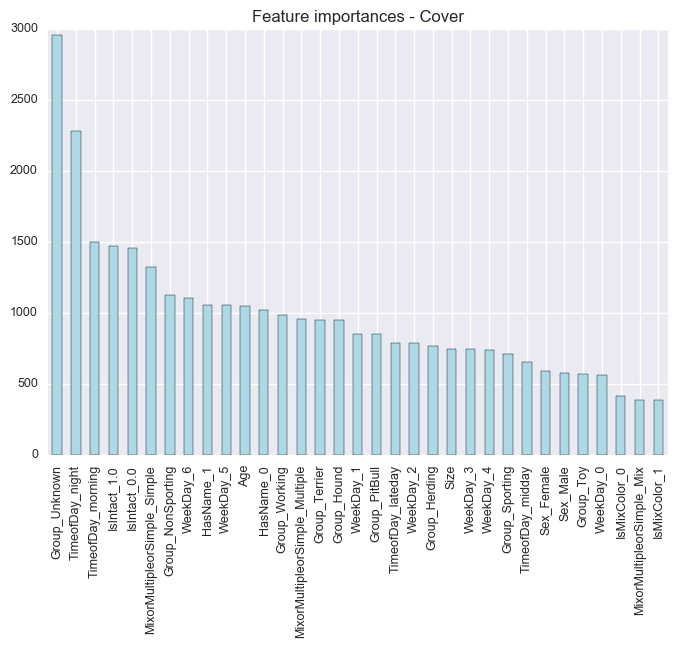

In [28]:
plt.figure(); ts3.plot(color="lightblue", kind="bar", title="Feature importances - Cover",fontsize=9,)

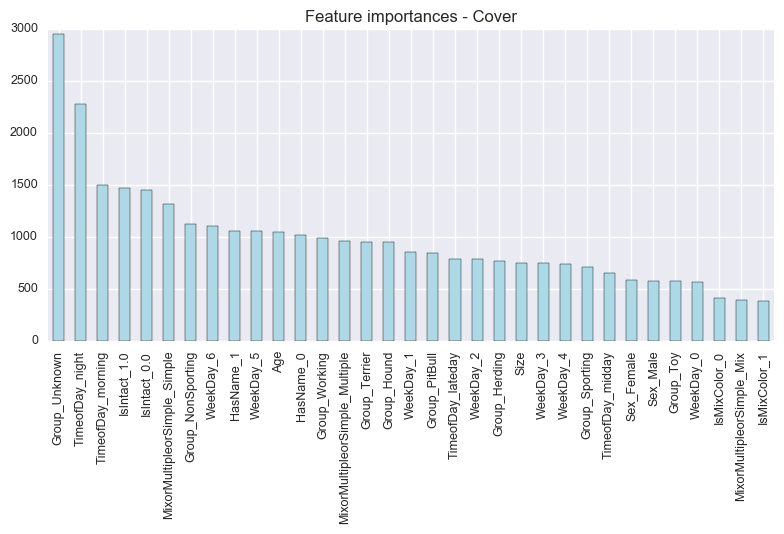

In [29]:
plt.figure(); ts3.plot(color="lightblue", kind="bar", title="Feature importances - Cover",fontsize=9,)
plt.tight_layout(rect=[0,0,1,1], h_pad=0.0)
plt.savefig("cover.png")